In [1]:
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

load_dotenv()

llm = init_chat_model("claude-sonnet-4-5-20250929")

In [2]:
from langgraph.graph import StateGraph
from langchain_core.messages import AnyMessage, HumanMessage

In [3]:
from typing import List, TypedDict

In [4]:

# Define the State using TypedDict
class ChatbotStateTD(TypedDict):
    messages: List[AnyMessage]

In [5]:
# Initial State
initial_state_typeddict = ChatbotStateTD(messages=[])
type(initial_state_typeddict)

dict

In [6]:

print(f"Initial State (TypedDict): {initial_state_typeddict}")

Initial State (TypedDict): {'messages': []}


In [7]:

# Initial State with dictionary
initial_state_typeddict = ChatbotStateTD({"messages": []})

print(f"Initial State (TypedDict): {initial_state_typeddict}")

Initial State (TypedDict): {'messages': []}


In [8]:
# Initial State with wrong types
initial_state_typeddict_1 = ChatbotStateTD({"messages": True})
initial_state_typeddict_2 = ChatbotStateTD({"messages": ["hello"]})

print(f"{initial_state_typeddict_1=}\n{initial_state_typeddict_2=}")

initial_state_typeddict_1={'messages': True}
initial_state_typeddict_2={'messages': ['hello']}


In [9]:
from pydantic import BaseModel, Field

In [10]:
# Define the State using TypedDict
class ChatbotStateBM(BaseModel):
    messages: List[AnyMessage] = Field(default_factory=list)

In [11]:
# Initial State
initial_state_pydantic = ChatbotStateBM()
initial_state_pydantic

ChatbotStateBM(messages=[])

In [12]:
print(f"Initial State (Pydantic): {initial_state_pydantic}")
print(f"Initial State (Pydantic): {initial_state_pydantic.model_dump()}")

Initial State (Pydantic): messages=[]
Initial State (Pydantic): {'messages': []}


In [13]:

# Initial State with non-default value
initial_state_pydantic = ChatbotStateBM(messages=[HumanMessage("Hello!")])
initial_state_pydantic

ChatbotStateBM(messages=[HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={})])

In [14]:
# Initial State with wrong type
initial_state_pydantic = ChatbotStateBM(messages="Hello!")

ValidationError: 1 validation error for ChatbotStateBM
messages
  Input should be a valid list [type=list_type, input_value='Hello!', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/list_type

In [15]:
# Define graph with multiple states (input, internal, and output)
class InputState(TypedDict):
    user_input: str

class OutputState(TypedDict):
    graph_output: str

class InternalState(TypedDict):
    internal_var: str
    user_input: str
    graph_output: str

graph = StateGraph(InternalState, input_schema=InputState, output_schema=OutputState)

#### We can also define private input and output state node states (images)

In [16]:
# Default reducer function
class State(TypedDict):
    foo: int
    bar: str
    baz: float

In [17]:
# Cutom reducer function
from typing import Annotated
from operator import add

def custom_reducer(old_value, new_value) -> float:
  return (old_value + new_value)/2

def increment(old_value, new_value) -> int:
  return old_value + 1

class State(TypedDict):
    foo: Annotated[float, custom_reducer]
    baz: Annotated[int, increment] # Count nbr of updates
    bar: Annotated[list[str], add]

In [18]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

In [20]:
# define state
class State(TypedDict):
    messages: Annotated[list, add_messages]

# define chatbot 1 node
def chatbot1(state: State) -> State:
    llm_response = "Hello from the chatbot1!"
    return {"messages": [llm_response]}

# define chatbot 2 node
def chatbot2(state: State) -> State:
    llm_response = "Hello from the chatbot2!"
    return {"messages": [llm_response]}

In [21]:
# Instantiate a graph builder
graph_builder = StateGraph(State)

# Add node
graph_builder.add_node("chatbot1", chatbot1)

# We can also add caching to an expensive node
graph_builder.add_node("chatbot2", chatbot2)

In [22]:

graph_builder.compile()

ValueError: Graph must have an entrypoint: add at least one edge from START to another node

In [23]:
from langgraph.graph import START, END

In [24]:

# define normal (direct) edge
graph_builder.add_edge(START, "chatbot1")

In [25]:
# define conditional edge
def routing_function(state: State) -> str:
    if len(state["messages"]) > 1000:
        return "chatbot2"
    return "chatbot1"

graph_builder.add_conditional_edges(START, routing_function)

In [26]:

# define conditional edge with path mapping
def use_chatbot2(state: State) -> str:
    if len(state["messages"]) > 1000:
        return True
    return False

graph_builder.add_conditional_edges(START, use_chatbot2, {True: "chatbot2", False:"chatbot1"})

In [27]:
from typing import Annotated, List
from pydantic import BaseModel

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.messages import AnyMessage

In [28]:
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

load_dotenv()

llm = init_chat_model("claude-sonnet-4-5-20250929")

In [29]:
# define state
class MessageState(BaseModel):
    messages: Annotated[List[AnyMessage], add_messages]  # from langgraph.graph import MessagesState


# define chatbot node
def chatbot(state: MessageState):
    reponse = llm.invoke(state.messages)
    return {"messages": [reponse]}

# create graph
graph_builder = StateGraph(MessageState)

# add nodes
graph_builder.add_node("chatbot", chatbot)

# add edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# compile graph
graph = graph_builder.compile()

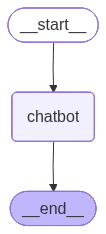

In [30]:
# visualize graph
graph

In [31]:

# run graph with invoke
final_state = graph.invoke({"messages":[{"role":"user",
                                         "content":"Hello!"
                                         }]
                            }) # can work with just ["hello!"] because we used predefined reducer

In [32]:
final_state

{'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='85b2d0a4-31e6-4416-ba87-bc08c6ddf91b'),
  AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'id': 'msg_01MnxVx6XqHbqMxU1s8MXdoW', 'model': 'claude-sonnet-4-5-20250929', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 9, 'output_tokens': 12, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-sonnet-4-5-20250929', 'model_provider': 'anthropic'}, id='lc_run--0598e82c-e399-4758-8db7-692d1aae9964-0', usage_metadata={'input_tokens': 9, 'output_tokens': 12, 'total_tokens': 21, 'input_token_details': {'cache_read': 0, 'cache_creation': 0, 'ephemeral_5m_input_tokens': 0, 'ephemeral_1h_input_tokens': 0}})]}

In [33]:
final_state["messages"][-1].content

'Hello! How can I help you today?'

In [39]:
# run graph with stream
final_state = graph.stream({"messages":["hello!"]}, stream_mode="values") # Emit all values in the state after each step

In [35]:
final_state

<generator object Pregel.stream at 0x00000279F5D0E2D0>

In [36]:
list(final_state)

[{'messages': [HumanMessage(content='hello!', additional_kwargs={}, response_metadata={}, id='d7160a93-30cb-42e1-a544-7ae2aae302d1')]},
 {'messages': [HumanMessage(content='hello!', additional_kwargs={}, response_metadata={}, id='d7160a93-30cb-42e1-a544-7ae2aae302d1'),
   AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'id': 'msg_01MZF1zm8beHEjesvDozZuos', 'model': 'claude-sonnet-4-5-20250929', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 9, 'output_tokens': 12, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-sonnet-4-5-20250929', 'model_provider': 'anthropic'}, id='lc_run--c8d011fa-6ecc-45bf-b6a5-8940e346c314-0', usage_metadata={'input_tokens': 9, 'output_tokens': 12, 'total_tokens': 21, 'input_token_details': {'cache_read': 0, 'cache_

In [37]:
import time

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        message.pretty_print()
        time.sleep(1)

In [40]:
print_stream(final_state)

================================ Human Message =================================

hello!
================================== Ai Message ==================================

Hello! How can I help you today?
